In [46]:
import pandas as pd
import pickle
from pathlib import Path
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

In [2]:
plt.style.use("dark_background")

In [3]:
this_file = os.path.abspath(".")
src_dir = Path(this_file).parent.parent.resolve()
sys.path.append(str(src_dir))

import src.config as cfg
import src.process.prep as prep

#### Data (all from FRED):
<ul>
  <li>Unemmployment Rate</li>
    <ul>
      <li>Monthly</li>
    </ul>
  <li>Natural Rate of Unemployment</li>
    <ul>
      <li>Quarterly</li>
    </ul>
  <li>CPI</li>
    <ul>
      <li>Monthly</li>
    </ul>
  <li>WTI Oil Px/Barrel</li>
    <ul>
      <li>Monthly</li>
    </ul>
  <li>Expected Inflation (1yr Out)</li>
    <ul>
      <li>Monthly</li>
    </ul>
</ul>

In [4]:
raw_data = prep.load_fred_data()
raw_data.index = raw_data.index.date
raw_data.head()

,UNRATE,CPIAUCSL,CUSR0000SEHE,WTISPLC,EXPINF1YR,NROU
1946-01-01,NaN,NaN,NaN,1.17,NaN,NaN
1946-02-01,NaN,NaN,NaN,1.17,NaN,NaN
1946-03-01,NaN,NaN,NaN,1.17,NaN,NaN
1946-04-01,NaN,NaN,NaN,1.27,NaN,NaN
1946-05-01,NaN,NaN,NaN,1.27,NaN,NaN


##### Preprocessing:
#### 1) Data for expected inflation is missing before 01-01-1981 so drop all data before then

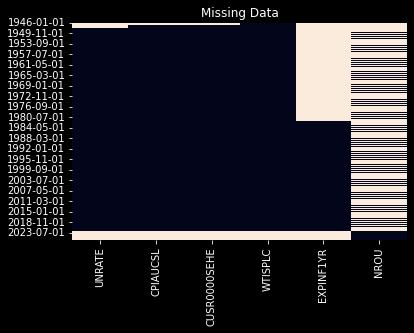

In [5]:
sns.heatmap(raw_data.isnull(), cbar=False).set(title="Missing Data")
plt.show()

In [6]:
prcsd_data = prep.drop_missing_data(raw_data, "EXPINF1YR")
prcsd_data.head()

,UNRATE,CPIAUCSL,CUSR0000SEHE,WTISPLC,EXPINF1YR,NROU
1982-01-01,8.6,94.4,103.5,33.85,6.394507,6.150627
1982-02-01,8.9,94.7,103.3,31.56,6.432108,NaN
1982-03-01,9.0,94.7,102.8,28.48,6.387732,NaN
1982-04-01,9.3,95.0,101.8,33.45,6.140628,6.141160
1982-05-01,9.4,95.9,101.6,35.93,5.488167,NaN


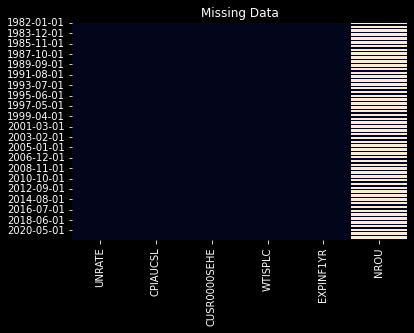

In [7]:
sns.heatmap(prcsd_data.isnull(), cbar=False).set(title="Missing Data")
plt.show()

#### 2) Calculate unemployment as:
<ul>
  <li>(Unemployment - Natural Rate) - (Unemployment Last Month - Natural Rate Last Month)</li>
</ul>

In [8]:
prcsd_data = prep.calc_unemployment(prcsd_data, unemp_col="UNRATE", nrunemp_col="NROU")
prcsd_data.head(12)

,UNRATE,CPIAUCSL,CUSR0000SEHE,WTISPLC,EXPINF1YR,NROU,nrate_ffilled,unemp_minus_nrate,unemp_chg
1982-01-01,8.6,94.4,103.5,33.85,6.394507,6.150627,6.150627,2.449373,NaN
1982-02-01,8.9,94.7,103.3,31.56,6.432108,NaN,6.150627,2.749373,0.300000
1982-03-01,9.0,94.7,102.8,28.48,6.387732,NaN,6.150627,2.849373,0.100000
1982-04-01,9.3,95.0,101.8,33.45,6.140628,6.141160,6.141160,3.158840,0.309467
1982-05-01,9.4,95.9,101.6,35.93,5.488167,NaN,6.141160,3.258840,0.100000
1982-06-01,9.6,97.0,103.3,35.07,5.445233,NaN,6.141160,3.458840,0.200000
1982-07-01,9.8,97.5,104.1,34.16,6.374885,6.131687,6.131687,3.668313,0.209473
1982-08-01,9.8,97.7,104.4,33.95,6.367801,NaN,6.131687,3.668313,0.000000
1982-09-01,10.1,97.7,103.9,35.63,6.339422,NaN,6.131687,3.968313,0.300000
1982-10-01,10.4,98.1,104.5,35.68,5.132758,6.122254,6.122254,4.277746,0.309433


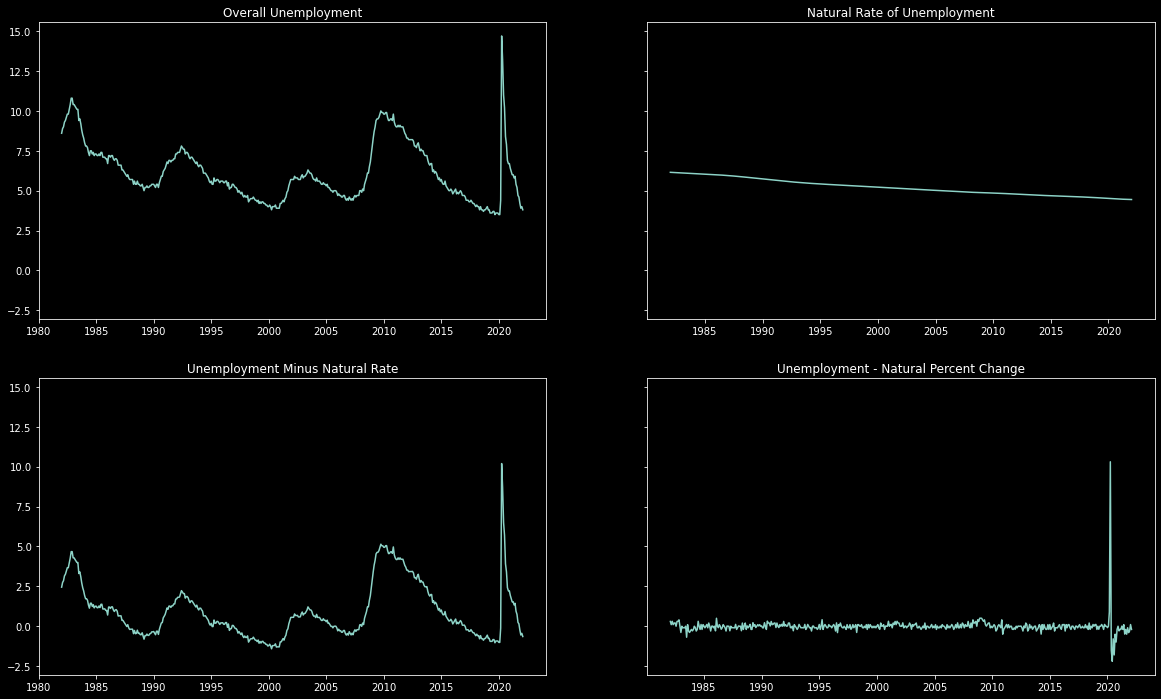

In [9]:
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(20, 12))

axs[0, 0].plot(prcsd_data.index, prcsd_data["UNRATE"])
axs[0, 0].title.set_text("Overall Unemployment")

axs[0, 1].plot(prcsd_data["NROU"].dropna().index, prcsd_data["NROU"].dropna())
axs[0, 1].title.set_text("Natural Rate of Unemployment")

axs[1, 0].plot(prcsd_data.index, prcsd_data["unemp_minus_nrate"])
axs[1, 0].title.set_text("Unemployment Minus Natural Rate")

axs[1, 1].plot(prcsd_data.index, prcsd_data["unemp_chg"])
axs[1, 1].title.set_text("Unemployment - Natural Percent Change")

plt.show()

#### 3) Calculate Oil Px as:
<ul>
  <li>(Oil Px - Oil Px Last Month) / Oil Px Last Month</li>
</ul>

In [10]:
prcsd_data = prep.calc_inflation(prcsd_data, "WTISPLC")
prcsd_data = prcsd_data.rename(columns={"inflation": "oil_px_chg"})
prcsd_data.head(13)

,UNRATE,CPIAUCSL,CUSR0000SEHE,WTISPLC,EXPINF1YR,NROU,nrate_ffilled,unemp_minus_nrate,unemp_chg,oil_px_chg
1982-01-01,8.6,94.4,103.5,33.85,6.394507,6.150627,6.150627,2.449373,NaN,NaN
1982-02-01,8.9,94.7,103.3,31.56,6.432108,NaN,6.150627,2.749373,0.300000,-0.067651
1982-03-01,9.0,94.7,102.8,28.48,6.387732,NaN,6.150627,2.849373,0.100000,-0.097592
1982-04-01,9.3,95.0,101.8,33.45,6.140628,6.141160,6.141160,3.158840,0.309467,0.174508
1982-05-01,9.4,95.9,101.6,35.93,5.488167,NaN,6.141160,3.258840,0.100000,0.074141
1982-06-01,9.6,97.0,103.3,35.07,5.445233,NaN,6.141160,3.458840,0.200000,-0.023935
1982-07-01,9.8,97.5,104.1,34.16,6.374885,6.131687,6.131687,3.668313,0.209473,-0.025948
1982-08-01,9.8,97.7,104.4,33.95,6.367801,NaN,6.131687,3.668313,0.000000,-0.006148
1982-09-01,10.1,97.7,103.9,35.63,6.339422,NaN,6.131687,3.968313,0.300000,0.049485
1982-10-01,10.4,98.1,104.5,35.68,5.132758,6.122254,6.122254,4.277746,0.309433,0.001403


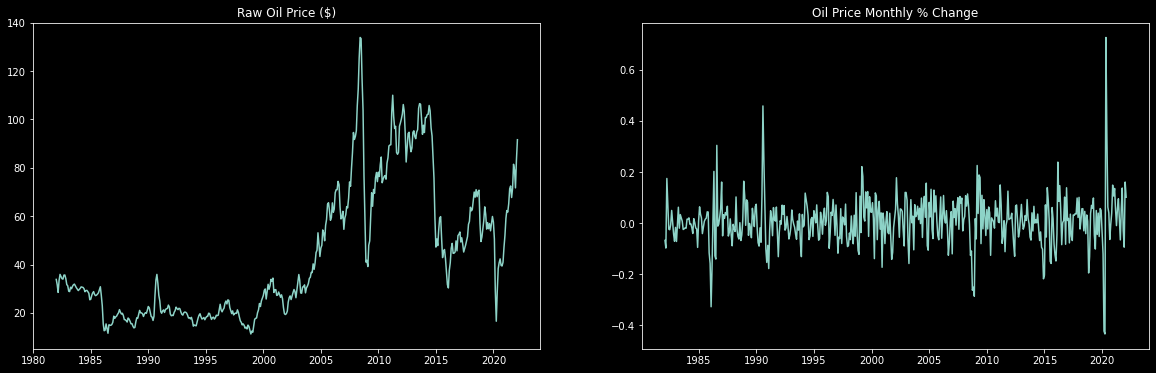

In [11]:

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

axs[0].plot(prcsd_data.index, prcsd_data["WTISPLC"])
axs[0].title.set_text("Raw Oil Price ($)")

axs[1].plot(prcsd_data.index, prcsd_data["oil_px_chg"])
axs[1].title.set_text("Oil Price Monthly % Change")

plt.show()

#### 4) Calculate Inflation as:
<ul>
  <li>(Px Level - Px Level Last Month) / Px Level Last Month</li>
</ul>

#### 5) Calculate Inflation Expectations as:
<ul>
  <li>((Expected Increase in Inflation in 12 Mo * Current Px Level + Current Px Level) / Current Px Level) ^ 1/12 - 1</li>
  <li>(Basically, solve backwards for "what is the monthly rate of inflation growth expected for the next 12 months?")
</ul>

In [12]:
prcsd_data = prep.calc_inflation(prcsd_data, "CPIAUCSL")
prcsd_data = prep.calc_expected_inflation(prcsd_data, "CPIAUCSL", "EXPINF1YR")
prcsd_data.head()

,UNRATE,CPIAUCSL,CUSR0000SEHE,WTISPLC,EXPINF1YR,NROU,nrate_ffilled,unemp_minus_nrate,unemp_chg,oil_px_chg,inflation,ecpi_t12,expected_inflation
1982-01-01,8.6,94.4,103.5,33.85,6.394507,6.150627,6.150627,2.449373,NaN,NaN,NaN,100.436415,NaN
1982-02-01,8.9,94.7,103.3,31.56,6.432108,NaN,6.150627,2.749373,0.300000,-0.067651,0.003178,100.791206,0.005179
1982-03-01,9.0,94.7,102.8,28.48,6.387732,NaN,6.150627,2.849373,0.100000,-0.097592,0.000000,100.749182,0.005208
1982-04-01,9.3,95.0,101.8,33.45,6.140628,6.141160,6.141160,3.158840,0.309467,0.174508,0.003168,100.833596,0.005173
1982-05-01,9.4,95.9,101.6,35.93,5.488167,NaN,6.141160,3.258840,0.100000,0.074141,0.009474,101.163152,0.004979


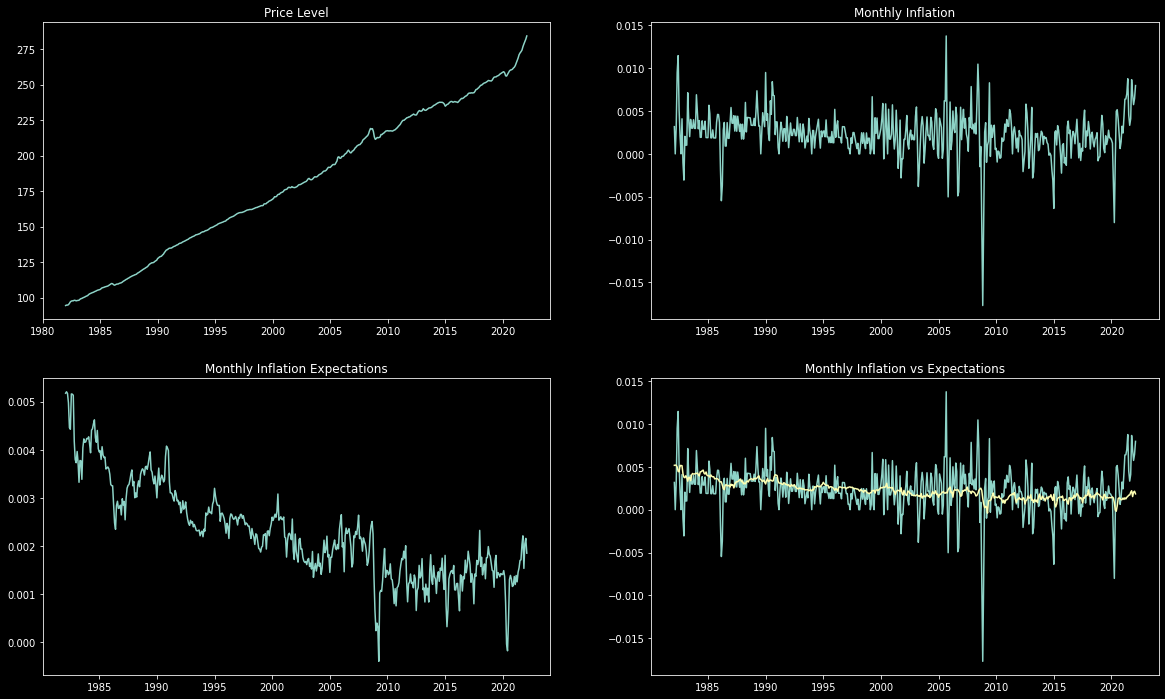

In [13]:
f, axs = plt.subplots(2, 2, figsize=(20, 12))

axs[0, 0].plot(prcsd_data.index, prcsd_data["CPIAUCSL"])
axs[0, 0].title.set_text("Price Level")

axs[0, 1].plot(prcsd_data.index, prcsd_data["inflation"])
axs[0, 1].title.set_text("Monthly Inflation")

axs[1, 0].plot(prcsd_data.index, prcsd_data["expected_inflation"])
axs[1, 0].title.set_text("Monthly Inflation Expectations")

axs[1, 1].plot(prcsd_data.index, prcsd_data["inflation"])
axs[1, 1].plot(prcsd_data.index, prcsd_data["expected_inflation"])
axs[1, 1].title.set_text("Monthly Inflation vs Expectations")

plt.show()

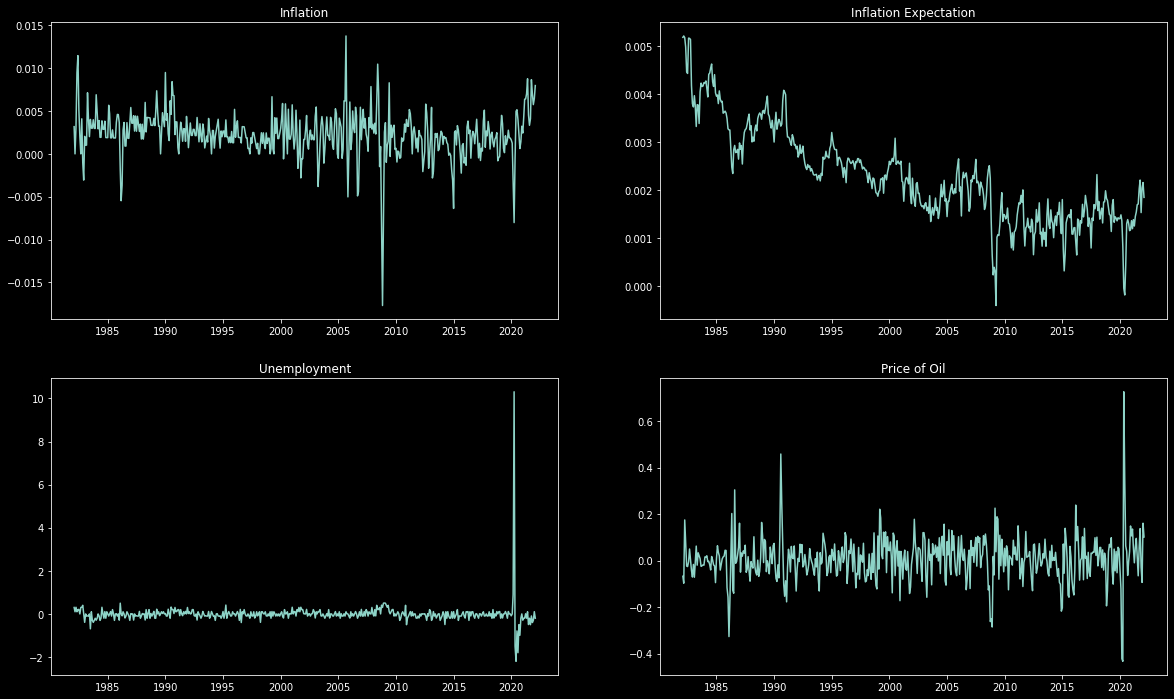

In [19]:
f, axs = plt.subplots(2, 2, figsize=(20, 12))

axs[0, 0].plot(prcsd_data.index, prcsd_data["inflation"])
axs[0, 0].title.set_text("Inflation")

axs[0, 1].plot(prcsd_data.index, prcsd_data["expected_inflation"])
axs[0, 1].title.set_text("Inflation Expectation")

axs[1, 0].plot(prcsd_data.index, prcsd_data["unemp_chg"])
axs[1, 0].title.set_text("Unemployment")

axs[1, 1].plot(prcsd_data.index, prcsd_data["oil_px_chg"])
axs[1, 1].title.set_text("Price of Oil")

plt.show()

In [16]:
final_df = prcsd_data[["inflation", "expected_inflation", "unemp_chg", "oil_px_chg"]].dropna()
final_df.to_pickle(cfg.DATA_DIR / "processed" / "nonstationary.pkl")

#### 5) Check PACF plots to see autocorrelation. There appears to be autocorrelation in all but unemployment (already been differenced)

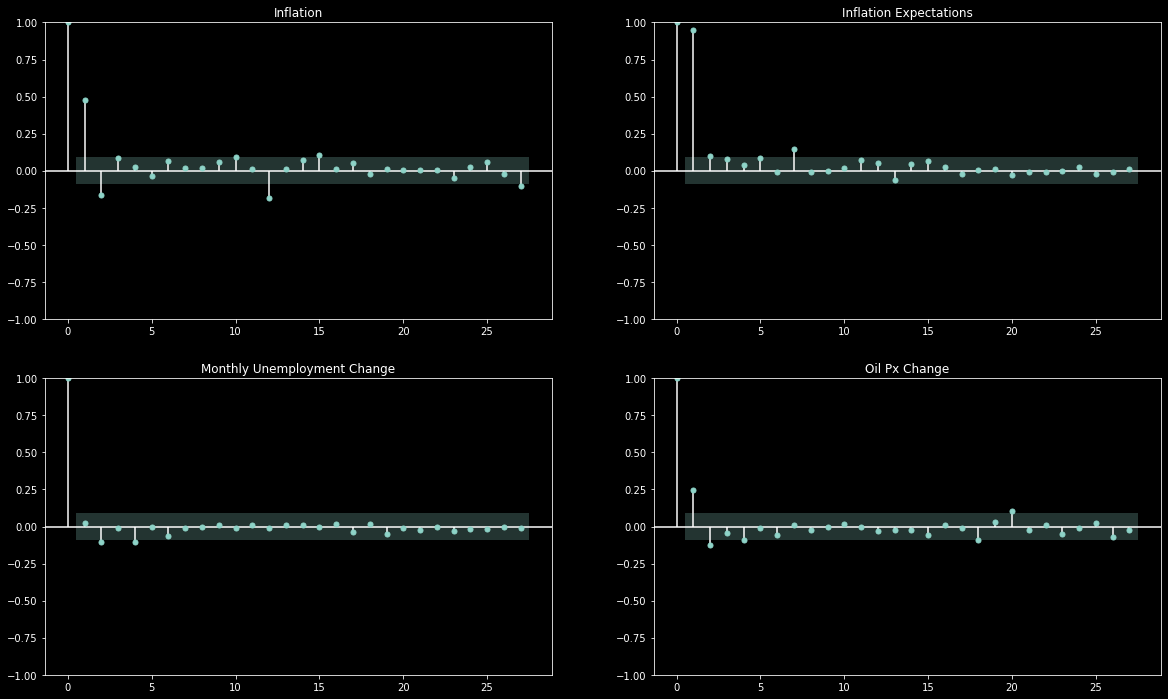

In [20]:
f, axs = plt.subplots(2, 2, figsize=(20, 12))

plot_pacf(prcsd_data["inflation"].dropna(), ax=axs[0, 0], method="ywm")
axs[0, 0].title.set_text("Inflation")

plot_pacf(prcsd_data["expected_inflation"].dropna(), ax=axs[0, 1], method="ywm")
axs[0, 1].title.set_text("Inflation Expectations")

plot_pacf(prcsd_data["unemp_chg"].dropna(), ax=axs[1, 0], method="ywm")
axs[1, 0].title.set_text("Monthly Unemployment Change")

plot_pacf(prcsd_data["oil_px_chg"].dropna(), ax=axs[1, 1], method="ywm")
axs[1, 1].title.set_text("Oil Px Change")

plt.show()

In [55]:
stationary = prcsd_data[["inflation", "expected_inflation", "unemp_chg", "oil_px_chg"]]
stationary["inflation"] = stationary["inflation"].diff()
stationary["expected_inflation"] = stationary["expected_inflation"].diff()
#stationary["avg_unemp"] = stationary["avg_unemp"].diff(12)
stationary["oil_px_chg"] = stationary["oil_px_chg"].diff()
stationary.head()

/var/folders/wm/rtb7thl52h7dylvtljg9_sr40000gn/T/ipykernel_81965/315392432.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationary["inflation"] = stationary["inflation"].diff()
/var/folders/wm/rtb7thl52h7dylvtljg9_sr40000gn/T/ipykernel_81965/315392432.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationary["expected_inflation"] = stationary["expected_inflation"].diff()
/var/folders/wm/rtb7thl52h7dylvtljg9_sr40000gn/T/ipykernel_81965/315392432.py:5: SettingWithCopyWarning: 
A value is trying to

,inflation,expected_inflation,unemp_chg,oil_px_chg
1982-01-01,NaN,NaN,NaN,NaN
1982-02-01,NaN,NaN,0.300000,NaN
1982-03-01,-0.003178,0.000030,0.100000,-0.029940
1982-04-01,0.003168,-0.000035,0.309467,0.272100
1982-05-01,0.006306,-0.000195,0.100000,-0.100368


#### 6) Difference all but unemployment

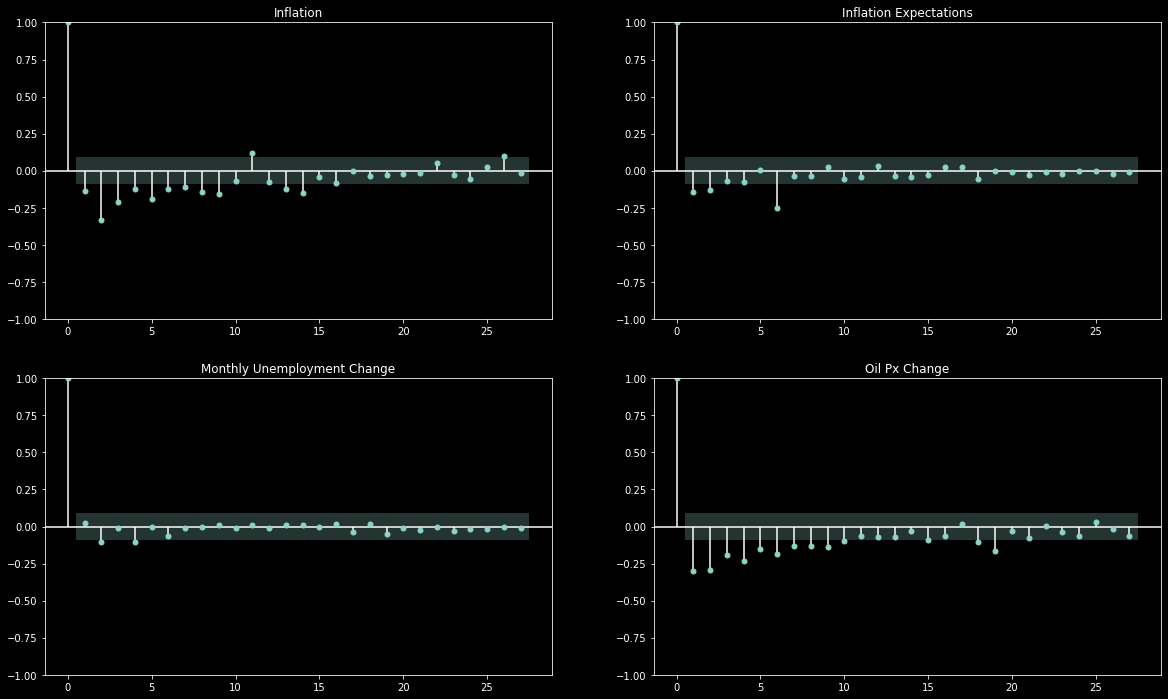

In [56]:

f, axs = plt.subplots(2, 2, figsize=(20, 12))

plot_pacf(stationary["inflation"].dropna(), ax=axs[0, 0], method="ywm")
axs[0, 0].title.set_text("Inflation")

plot_pacf(stationary["expected_inflation"].dropna(), ax=axs[0, 1], method="ywm")
axs[0, 1].title.set_text("Inflation Expectations")

plot_pacf(stationary["unemp_chg"].dropna(), ax=axs[1, 0], method="ywm")
axs[1, 0].title.set_text("Monthly Unemployment Change")

plot_pacf(stationary["oil_px_chg"].dropna(), ax=axs[1, 1], method="ywm")
axs[1, 1].title.set_text("Oil Px Change")

plt.show()

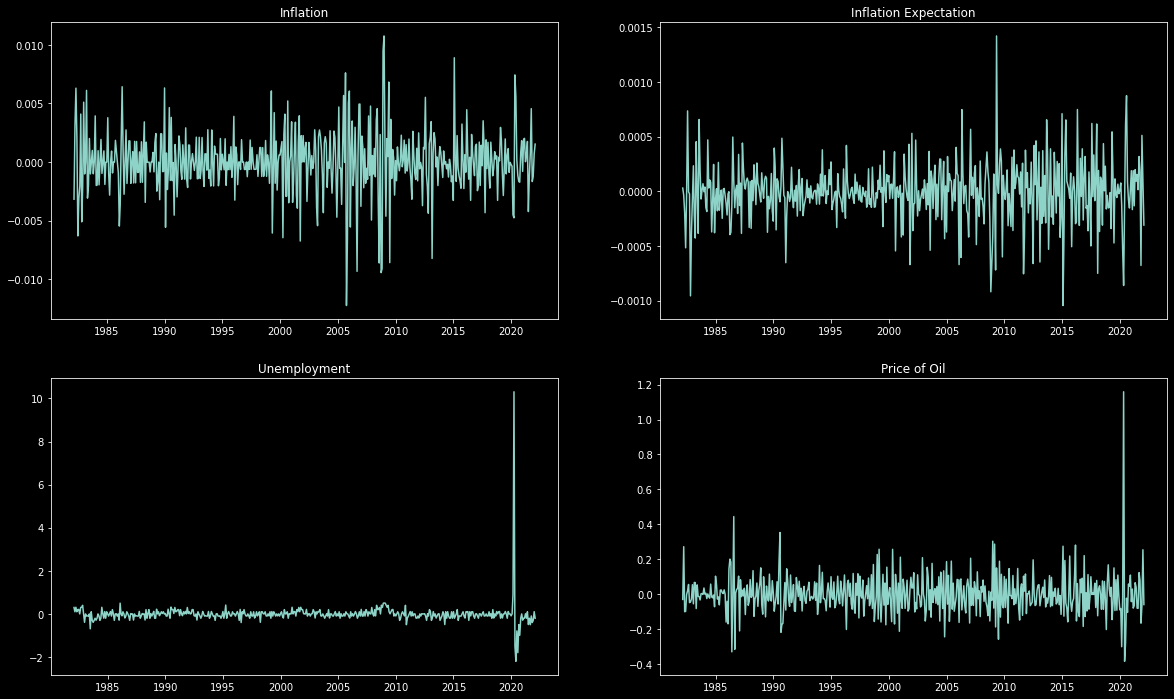

In [28]:

f, axs = plt.subplots(2, 2, figsize=(20, 12))

axs[0, 0].plot(stationary.index, stationary["inflation"])
axs[0, 0].title.set_text("Inflation")

axs[0, 1].plot(stationary.index, stationary["expected_inflation"])
axs[0, 1].title.set_text("Inflation Expectation")

axs[1, 0].plot(stationary.index, stationary["unemp_chg"])
axs[1, 0].title.set_text("Unemployment")

axs[1, 1].plot(stationary.index, stationary["oil_px_chg"])
axs[1, 1].title.set_text("Price of Oil")

plt.show()

### 7) Run Augmented Dickey Fuller tests to confirm stationary vectors

In [52]:
no_na = stationary.copy().dropna()
pvalues = [adfuller(no_na[col])[1] for col in no_na]
if any(pvalue > 0.05 / 4 for pvalue in pvalues):
    print("Non-stationary series in dataframe")
else:
    print("All series stationary")

All series stationary


In [47]:
with open(cfg.DATA_DIR / "processed" / "final_data.pkl", "wb") as handle:
    pickle.dump(no_na, handle, protocol=pickle.HIGHEST_PROTOCOL)